#  <center> <font style="color:rgb(100,109,254)"> Video Stabilization  </font> </center>

Have you seen those videos in which the the video is unstable (shifting a lot) this is mostly due to the fact it was recorded from a hand held device (e.g your phone). Now its very likely this could have happened with you, you captured a beautiful moment of your friend or relative doing something and everything if perfect except the fact that video is shaking a bit giving the viewer a headache in making out what's happening, this is because you were maybe too excited to hold the camera still at the time.

**Look at below example:** *Unstabilized Feed Left, Stabilized Feed Right*

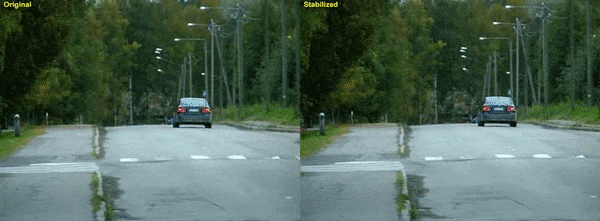

Today you'll learn how to stabilize those videos, so you enjoy them truly without the jitters and shakes. So we're going to be looking at **Video Stabilization**.


## <font style="color:rgb(134,19,348)">  Applications of Video Stabilization:</font>
Video stabalization is used across many domains, some of these are:

- **Videography:** Probably the first thing you can think of is Professional photography, the people in this industry make heavy use of this as reflected by their finished videos. And even when they do still photography with long exposure times, video stabilization can help there too.

- **Drones and Rough terrain robots:** The camera mounted on these will contain a lot of jittery feed and motion blur, so if a human is to observe the video input of a drone or a  you probably need to stabilize this.

**<center>Similarly in other domains where there is jitter, Video stabilization is used.</center>**


## <font style="color:rgb(134,19,348)"> Types of Video Stabilization Methods:   </font>

There are different types of Video Stabilization methods, the aim of all of them is the same, its to reduce the effect of camera motion, this motion can be translation in x,y or z direction or it can be rotation (in plane and out of plane rotations). 


- **Hardware Video Stabilization:** These methods uses gyros and accelerometer sensors to detect motion and then move the image sensors to compensate for camera motion.


- **Optical Video Stabilization:** In this method, stabilization is performed by moving parts of the lens. It varies the optical path (path of light) to the sensor.


- **Digital Video Stabilization:**  In this method you don't manipulate any sensors but write a software program to stabilize the video. So what you essentially do is shift video frames enough so it counteract motion. So the main Idea is simple you make sure the image features across frames have approximately same x,y locations.  


For more information on Video/image Stabilization I'd recommend you to read this [Wikipedia Article.](https://en.wikipedia.org/wiki/Image_stabilization#Application_in_still_photography)

Since this is a computer vision course, we'll implement a Digital video stabilization method. 
This stabilization can be implemented with OpenCV, an example pipeline of this is below.

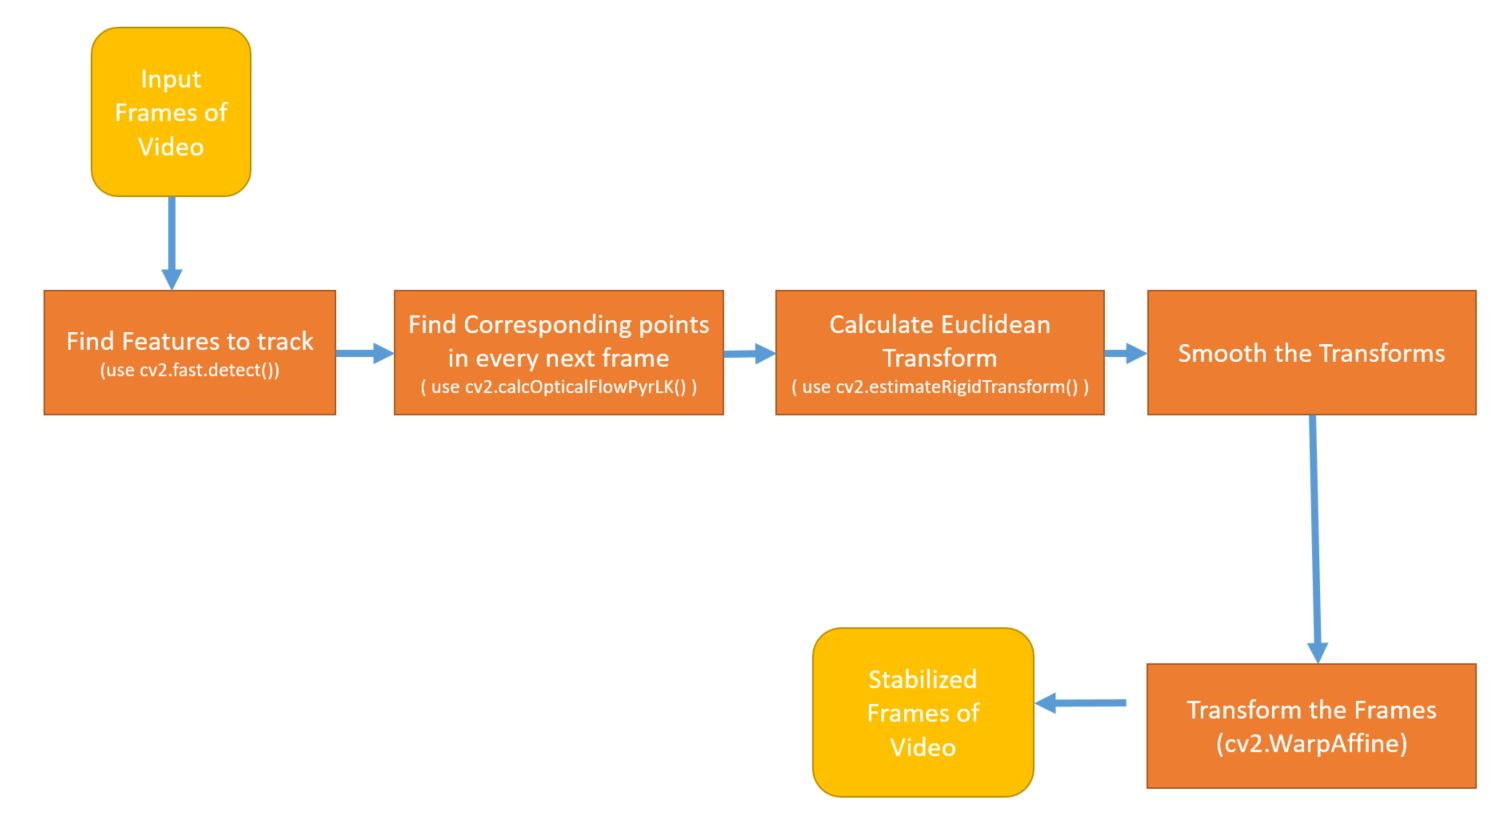


**Note: <font style="color:rgb(243,133,128)"> Did you know We and many other animals have a built in video stabilization system, our inner ear functions like an accelerometer does in stabilization systems, it stabilizes the image for the eyes when there is head motion.  </font>**



In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

## <font style="color:rgb(134,19,348)"> Step 1: Read Input Video & Setup Required Variables  </font>

In [288]:
# I'm reading an Unstabilized video of a cat.
cap = cv2.VideoCapture('media/M4/ostrich.mp4')

# Extract width and height of the video 
width = int(cap.get(3))
height = int(cap.get(4))

# Grab the number of frames in the video
Frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read the initial Frame
ret, frame   = cap.read()

# Convert to Grayscale.
previous_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

print('Total Frames in the Video: {}'.format(Frames_count))

Total Frames in the Video: 312


<font style="color:rgb(134,19,348)">  <h1> <center> Step 2-4 </center> </h1>  </font>

### <font style="color:rgb(134,19,348)"> Step 2: Find Features to Track   </font>
Remember I said to perform stabilization you essentially shift frames to counteract motion, now this shifting is just an Euclidean Transformation (Translation, rotation) between frames. To perform this transformation successfully between frames we need at least 2 corresponding points, (In actual we will store more points for estimation).

We know some good feature detectors, so we'll use FAST detector since its Fast. You can choose any other detector, even goodFeaturestoTrack would work too.

### <font style="color:rgb(134,19,348)"> Step 3: Apply Optical Flow to track features between Frames.   </font>
Now for all the frames you will track the features between a previous frame and the current frame. We can do this with **Sparse Optical Flow** using OpenCV's Lucas-Knade Optical Flow. We will use **cv2.calcOpticalFlowPyrLK()** for this.

### <font style="color:rgb(134,19,348)">   Step 4: Estimate Euclidean Transform. </font>
Now we know the location of some features in the previous frame and the location of those in the current frame, we can use this information to perform a rigid (Euclidean) transformation which will map the previous frame to the current frame.

An example of Euclidean transform can be seen below:

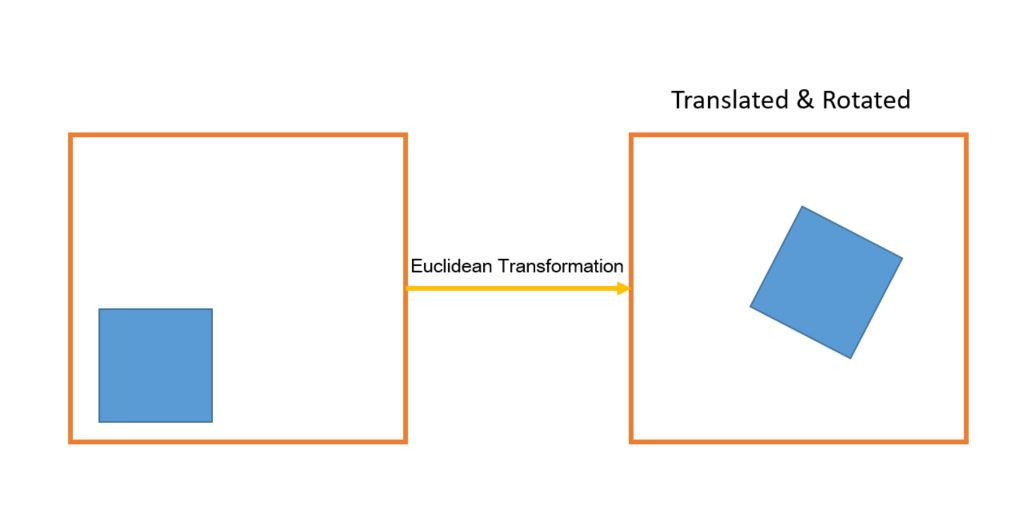

## <font style="color:rgb(134,19,348)">Applying the Above Steps For All Frames    </font>

In [289]:
# This array will store motion between frames. 
transformations = np.zeros((Frames_count-1, 3))

# Lucas kanade params for optical flow
lk_params = dict(winSize = (14, 14), maxLevel = 4,  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 0.03))

# Initialize FAST object with a threshold of 50
fast = cv2.FastFeatureDetector_create(50) 

for i in range(Frames_count-2):
    
     
  # Detect keypoint of Feature points in the previous frame
  kp = fast.detect(previous_frame, None)

  # Extract feature points and change them to the required format
  previous_pts = np.array([kp[x].pt for x in range(len(kp))], np.float32 ).reshape(-1,1,2)
    
  # Read next frame
  ret, frame = cap.read() 
  if not ret: 
    break
 
  # Convert to Grayscale
  current_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
 
  # Calculate Optical Flow to track the feature points in the current frame
  current_pts, status, err = cv2.calcOpticalFlowPyrLK(previous_frame, current_frame, previous_pts, None, **lk_params) 
    
  if status is None:
      continue
 
  # Grab the index of points that were Correctly tracked.
  index = np.where(status==1)[0]

  # Filter
  previous_pts = previous_pts[index]
  current_pts  = current_pts[index]
 
  # Find the Euclidean transformation matrix
  matrix = cv2.estimateAffinePartial2D(previous_pts, current_pts)

  # Remember this is how an euclidean matrix looks
  #     matrix =  [[ costheta,   sintheta,    x]
  #                [ -sintheta,  costheta,    y] ]

  # Get traslation in x,y direction
  x = matrix[0][0,2]
  y = matrix[0][1,2]
 
  # Get the rotation angle
  angle = np.arctan2(matrix[0][1,0], matrix[0][0,0])
    
  # Store transformation.
  transformations[i] = [x, y, angle]
    
  # At the end current frame becomes the previous frame
  previous_frame = current_frame
    
  # Display number of points tracked   
  if i % 50 == 0:
     print('Frame No: {}  Points Tracked Successfully: {}'.format(i+1, len(current_pts)))

Frame No: 1  Points Tracked Successfully: 145
Frame No: 51  Points Tracked Successfully: 213
Frame No: 101  Points Tracked Successfully: 150
Frame No: 151  Points Tracked Successfully: 198
Frame No: 201  Points Tracked Successfully: 222
Frame No: 251  Points Tracked Successfully: 32


Now that we have stored an array consisting of 3 different quantities, changes in x,y and angle over all the frames, Now these 3 different quantities can be 3 different curves if you plot them. And if you do then you'll notice that they are pretty noisy, so what you'll do now is smooth them, one easy and a very popular way of smoothing a quantity over time is using a *moving average filter*. What this essentially does is the following:

It replaces each value at the point by the average of its n neighbors (where n is the smoothing_window defined by the user), greater the window, greater the smoothing.

lets see an example, consider one of the curves, lets say all our x values is stored in an array called `x` so all the points in this array are  $x[0] … x[n-1]$. If `S` is the smoothed curve we obtain by filtering `x` with a moving average filter of `smoothing_window = 7` then the $k^{th}$ element of this curve can be mathimatically calculated as:

$$
  \begin{align*} S[k] = \frac{x[k-3] + x[k-2] + x[k-1] + x[k] + x[k+1] + x[k+2] + x[k+3]}{7} \end{align*}
$$


See below, the red curve is our original noisy curve for changes in x values and the blue curve is the smoothed curve due to moving average filter with a smoothing window of 30 frames.

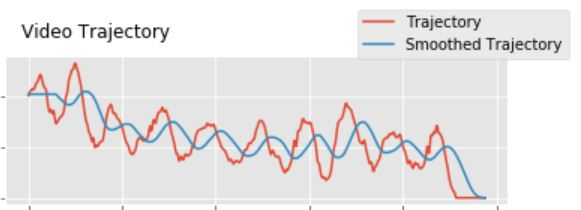

## <font style="color:rgb(134,19,348)"> Step 5 Smooth the Curves   </font>
A series of steps explained in comments need to be performed to smooth the curves, this step can be improved with padding and more functions which would yield greater results.

In [296]:
def smooth_with_moving_average(transformations, window_size = 60):
    
  # Computing trajectory using the cumulative sum of transformations
  trajectory = np.cumsum(transformations, axis=0)
    
  # Create a place holder variable for smoothed trajectory
  smoothed_trajectory = np.zeros_like(trajectory) 
    
  # Now for each of the curves (x, y, angle) smooth them.
  for i in range(3):
      
      # Get a single curve
      curve = trajectory[:,i]
        
      # Create a kernel
      kernel = np.ones(window_size)/window_size 
       
      # Apply smoothing with the kernel.
      smoothed_curve = np.convolve(curve, kernel, mode='same')  
    
      # Store the smoothed curve.
      smoothed_trajectory[:,i] = smoothed_curve
 
  # Calculate difference between smoothed_trajectory and the original trajectory
  diff = smoothed_trajectory - trajectory
  
  # Calculate the new transformation array by addding the difference 
  smooth_transformations = transformations + diff

  return smooth_transformations

**Now Use the method above to smooth the transformations.**

In [297]:
smooth_transformations = smooth_with_moving_average(transformations)

## <font style="color:rgb(134,19,348)"> Step 6: Transform the Frames and Stabilize the video   </font>
Now use the smoothed transformations to extract the smoothed arrays, construct the euclidean matrix again and use **warpAffine** to warp all the frames using the matrix.

In [299]:
# Reset the Video stream to first frame, or read the video again
cap.set(cv2.CAP_PROP_POS_FRAMES, 1)

# Make the video writer object to save the final stabilized video
out = cv2.VideoWriter('media/M4/Final_output.avi', cv2.VideoWriter_fourcc(*'XVID'), 20, (width, height))

# Stabilize each frame
for i in range(Frames_count-2):
    
  ret, frame = cap.read() 
  if not ret:
    break
 
  # Extract the new smoothed arrays from the transformations.
  x = smooth_transformations[i,0]
  y = smooth_transformations[i,1]
  angle = smooth_transformations[i,2]
 

  matrix = np.array(  [ [np.cos(angle), -np.sin(angle), x],
                      [np.sin(angle),  np.cos(angle), y] ]  , np.float32)
 
  # Apply affine wrapping to the given frame
  stabilized_frame = cv2.warpAffine(frame, matrix, (width,height))

  # Save the stabilized frame
  out.write(frame_out)
 
  # Show the original frame and stabilized frame side by side.
  stacked = np.hstack((frame,stabilized_frame))
  cv2.imshow("Result", stacked)
  cv2.waitKey(30)

cv2.destroyAllWindows()
out.release()

<center>Video from <i>Happyliving</i> </center>

**Note:** *This stabilization will perform best if the jitter and motion is small, it can also work in real time. You can make more modifications (specially to smoothing part) to improve this result, later we'll see a library called Vidstab which improves on this and even has a method to perform stabilization on live camera feed.*